In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import torch
import numpy as np
import pandas as pd
import meerkat as mk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dcbench import SliceDiscoverySolution

from domino.eval.metrics import compute_solution_metrics
from domino import explore, DominoSlicer, embed
from domino.utils import seed_everything

In [4]:
import os
# os.environ["DCBENCH_CONFIG"] = "/home/sabri/code/dcbench/dcbench-config.yaml"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

from tqdm import tqdm

import dcbench
sd = dcbench.tasks["slice_discovery"]

In [5]:
sd.problems

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2000,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6000,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2000,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6000,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2000,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
...,...,...,...,...,...,...
p_122649,0.2000,imagenet,5,noisy_label,[watch.n.01],timepiece.n.01
p_117333,0.0500,imagenet,5,rare,[cart.n.01],vehicle.n.01
p_118951,0.0500,imagenet,5,rare,[punch.n.02],food.n.01
p_120032,0.0500,imagenet,5,rare,[mushroom.n.05],vegetable.n.01


In [6]:
def get_slices(tasks, slice_type='rare'):
    ids = []
    print(f'Collecting {slice_type} slices:')
    for id in tqdm(tasks):
        if tasks[id]._attributes['slice_category'] == slice_type:
            ids.append(id)
    return ids

In [6]:
rare_tasks = get_slices(sd.problems, slice_type='rare')

100%|██████████| 886/886 [00:00<00:00, 577939.87it/s]


In [7]:
len(rare_tasks), rare_tasks[-5:]

(118, ['p_121242', 'p_117333', 'p_118951', 'p_120032', 'p_118660'])

In [7]:
task = 'p_121023'
print(sd.problems[task]._attributes)
problem = sd.problems[task]

{'alpha': 0.029240177382128654, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['tiger.n.02'], 'target_name': 'big_cat.n.01'}


In [8]:
problem

SliceDiscoveryProblem(artifacts={'activations': 'DataPanelArtifact', 'base_dataset': 'VisionDatasetArtifact', 'clip': 'DataPanelArtifact', 'model': 'ModelArtifact', 'test_predictions': 'DataPanelArtifact', 'test_slices': 'DataPanelArtifact', 'val_predictions': 'DataPanelArtifact'}, attributes={'alpha': 0.029240177382128654, 'dataset': 'imagenet', 'n_pred_slices': 5, 'slice_category': 'rare', 'slice_names': ['tiger.n.02'], 'target_name': 'big_cat.n.01'})

In [9]:
problem['test_slices']

,id (PandasSeriesColumn),slices (NumpyArrayColumn)
0,n03868863_1406,[0.0]
1,n02095889_1916,[0.0]
2,n04366367_3683,[0.0]
3,n02130308_25695,[0.0]
4,n04259630_5114,[0.0]
...,...,...
5900,n03796401_3092,[0.0]
5901,n02091032_2681,[0.0]
5902,n04509417_1235,[0.0]
5903,n02130308_8390,[0.0]


In [10]:
problem['test_predictions']

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ml/__init__.py:7: ExperimentalWarning: The `meerkat.ml` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n03868863_1406,0,"[tensor(0.9778), tensor(0.0222)]",test
1,n02095889_1916,0,"[tensor(0.9917), tensor(0.0083)]",test
2,n04366367_3683,0,"[tensor(0.9988), tensor(0.0012)]",test
3,n02130308_25695,1,"[tensor(0.0117), tensor(0.9883)]",test
4,n04259630_5114,0,"[tensor(0.9988), tensor(0.0012)]",test
...,...,...,...,...
5900,n03796401_3092,0,"[tensor(0.8607), tensor(0.1393)]",test
5901,n02091032_2681,0,"[tensor(0.9987), tensor(0.0013)]",test
5902,n04509417_1235,0,"[tensor(0.9938), tensor(0.0062)]",test
5903,n02130308_8390,1,"[tensor(4.1024e-06), tensor(1.0000)]",test


In [11]:
problem['val_predictions']

,id (PandasSeriesColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn)
0,n02099601_2391,0,"[tensor(0.9812), tensor(0.0188)]",valid
1,n02128757_6438,1,"[tensor(3.2006e-05), tensor(1.0000)]",valid
2,n02128757_11473,1,"[tensor(0.7602), tensor(0.2398)]",valid
3,n02128925_10728,1,"[tensor(0.0006), tensor(0.9994)]",valid
4,n03871628_11357,0,"[tensor(0.9812), tensor(0.0188)]",valid
...,...,...,...,...
3042,n02011460_8718,0,"[tensor(0.9939), tensor(0.0061)]",valid
3043,n02009912_10484,0,"[tensor(0.9899), tensor(0.0101)]",valid
3044,n02096177_8672,0,"[tensor(0.9934), tensor(0.0066)]",valid
3045,n03196217_4749,0,"[tensor(0.9998), tensor(0.0002)]",valid


In [12]:
test_dp = mk.merge(problem["test_slices"], problem["test_predictions"], on="id")
test_dp = mk.merge(problem["base_dataset"], test_dp, on="id")
test_dp["pred"] = test_dp["probs"][:, 1]

val_dp = mk.merge(problem["val_predictions"], problem["base_dataset"], on="id") 
val_dp["pred"] = val_dp["probs"][:, 1]

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


## Embed Images

In [13]:
# from domino import embed
# val_dp = embed(
#     val_dp, 
#     input_col="image",
#     device=0
# )
# test_dp = embed(
#     test_dp, 
#     input_col="image",
#     device=0
# )

In [14]:
test_dp.columns

['id', 'image', 'name', 'synset', 'slices', 'target', 'probs', 'split', 'pred']

## Load Embeddings

In [15]:
emb_dp = mk.DataPanel.read("image_embs.mk")

In [16]:
val_dp = val_dp.merge(emb_dp["id", "clip(image)"], on="id", how="left")
test_dp = test_dp.merge(emb_dp["id", "clip(image)"], on="id", how="left")

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [17]:
pca = PCA(n_components=2)
emb_val = pca.fit_transform(val_dp["clip(image)"].to_numpy())
emb_test = pca.fit_transform(test_dp["clip(image)"].to_numpy())

In [18]:
y_val = val_dp['target'].to_numpy()
y_hat_val = val_dp['pred'].to_numpy()

pred_val = np.where(y_hat_val > 0.5, 1, 0)

error_labels_val = np.ones(len(y_val)) * 2
error_labels_val[np.where(y_val*pred_val==1)[0]] = 0  # correctly classified
error_labels_val[np.where(y_val > pred_val)[0]] = 1   # false negatives
error_labels_val

array([2., 0., 1., ..., 2., 2., 2.])

In [19]:
y_test = test_dp['target'].to_numpy()
y_hat_test = test_dp['pred'].to_numpy()

pred_test = np.where(y_hat_test > 0.5, 1, 0)

error_labels_test = np.ones(len(y_test)) * 2
error_labels_test[np.where(y_test*pred_test==1)[0]] = 0  # correctly classified
error_labels_test[np.where(y_test > pred_test)[0]] = 1   # false negatives
error_labels_test

array([2., 2., 2., ..., 2., 2., 0.])

Text(0.5, 1.0, 'CLIP embeddings (test)')

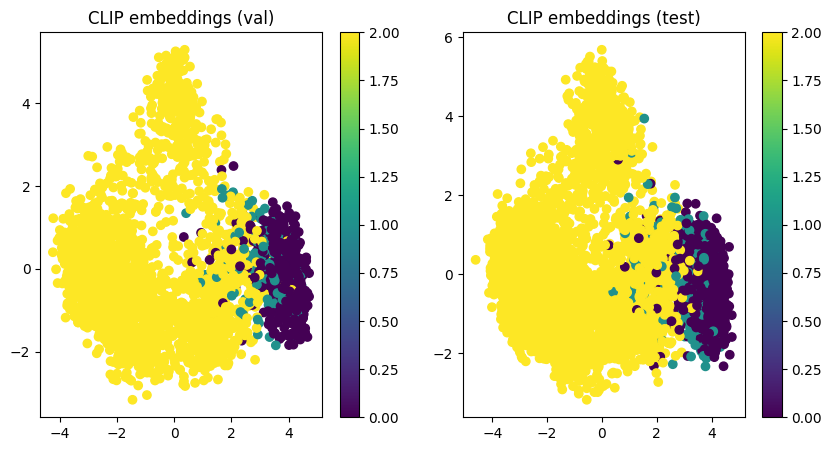

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(emb_val[:, 0], emb_val[:, 1], c=error_labels_val)
plt.colorbar()
plt.title("CLIP embeddings (val)")

plt.subplot(1, 2, 2)
plt.scatter(emb_test[:, 0], emb_test[:, 1], c=error_labels_test)
plt.colorbar()
plt.title("CLIP embeddings (test)")

In [21]:
pca128 = PCA(n_components=128)
emb128_val = pca128.fit_transform(val_dp["clip(image)"].to_numpy())
emb128_test = pca128.fit_transform(test_dp["clip(image)"].to_numpy())

Text(0.5, 1.0, 'PCA embeddings (test)')

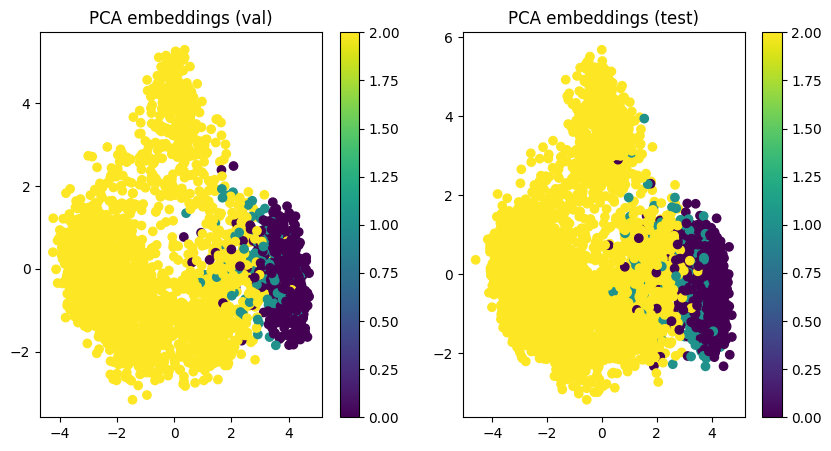

In [22]:
pca = PCA(n_components=2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
emb_pca = pca.fit_transform(emb128_val)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=error_labels_val)
plt.colorbar()
plt.title("PCA embeddings (val)")

plt.subplot(1, 2, 2)
emb_pca = pca.fit_transform(emb128_test)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=error_labels_test)
plt.colorbar()
plt.title("PCA embeddings (test)")

## Slice

In [55]:
seed_everything(0)
domino_config = {
    'n_slices': 25,
    'n_mixture_components': 25,
    'y_log_likelihood_weight': 20,
    'y_hat_log_likelihood_weight': 20,
    'init_params': 'confusion',
    'embedder': 'contrastive'
}
domino = DominoSlicer(
    **domino_config
)

In [56]:
domino.fit(data=val_dp, embeddings="clip(image)", targets="target", pred_probs="pred")

epoch 0 | c_loss: 1.8468 | r_loss: 0.8021 | cov: -0.6760: 100%|█| 10/10 [
epoch 1 | c_loss: 1.5169 | r_loss: 0.5990 | cov: -0.5418: 100%|█| 10/10 [
epoch 2 | c_loss: 1.3290 | r_loss: 0.4662 | cov: 0.0686: 100%|█| 10/10 [0
epoch 3 | c_loss: 1.1863 | r_loss: 0.4009 | cov: -0.0883: 100%|█| 10/10 [
epoch 4 | c_loss: 1.0498 | r_loss: 0.3486 | cov: 1.9299: 100%|█| 10/10 [0
epoch 5 | c_loss: 0.9818 | r_loss: 0.2788 | cov: 0.6865: 100%|█| 10/10 [0
epoch 6 | c_loss: 0.5317 | r_loss: 0.2684 | cov: 1.0514: 100%|█| 10/10 [0
epoch 7 | c_loss: 0.6379 | r_loss: 0.1988 | cov: -1.5518: 100%|█| 10/10 [
epoch 8 | c_loss: 0.4168 | r_loss: 0.1600 | cov: -4.0659: 100%|█| 10/10 [
epoch 9 | c_loss: 0.1629 | r_loss: 0.1761 | cov: -1.1483: 100%|█| 10/10 [
epoch 10 | c_loss: 0.1738 | r_loss: 0.1789 | cov: -1.5237: 100%|█| 10/10 
epoch 11 | c_loss: 0.0471 | r_loss: 0.1000 | cov: 2.3079: 100%|█| 10/10 [
epoch 12 | c_loss: 0.2136 | r_loss: 0.1185 | cov: -0.3059: 100%|█| 10/10 
epoch 13 | c_loss: 0.0365 | r_loss: 0.

  0%|          | 0/100 [00:00<?, ?it/s]

MixtureSlicer(embedder='contrastive', n_slices=25,
              y_hat_log_likelihood_weight=20, y_log_likelihood_weight=20)

In [57]:
cont128_val = domino.encoder.transform(domino.pca.transform(val_dp["clip(image)"].to_numpy()))
cont128_test = domino.encoder.transform(domino.pca.transform(test_dp["clip(image)"].to_numpy()))

Text(0.5, 1.0, 'Contrastive learned embeddings (test)')

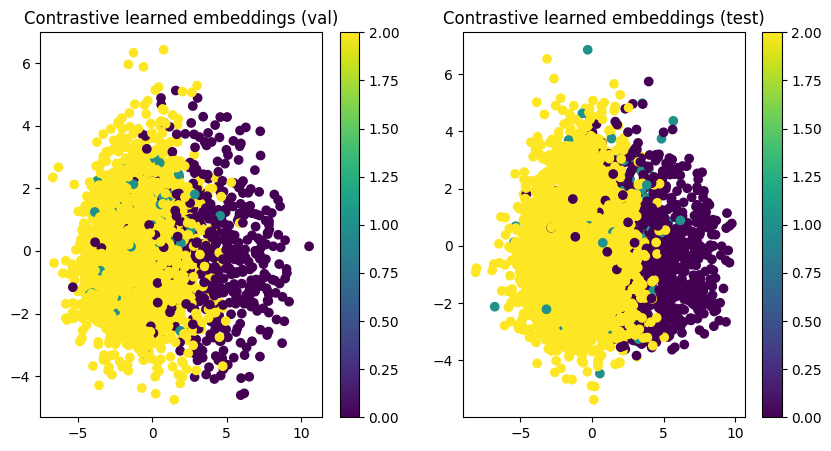

In [58]:
pca = PCA(n_components=2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cont_pca = pca.fit_transform(cont128_val)
plt.scatter(cont_pca[:, 0], cont_pca[:, 1], c=error_labels_val)
plt.colorbar()
plt.title("Contrastive learned embeddings (val)")

plt.subplot(1, 2, 2)
cont_pca = pca.fit_transform(cont128_test)
slices = test_dp['slices'].reshape(-1,)
plt.scatter(cont_pca[:, 0], cont_pca[:, 1], c=error_labels_test)
plt.colorbar()
plt.title("Contrastive learned embeddings (test)")

In [59]:
domino.err_entropy

array([ 2.52399626e-02,  1.20440495e-01,  6.64515899e-01,  5.73145567e-02,
        4.58530728e-02,  1.13712345e-01,  4.02580048e-01,  4.18490570e-08,
        6.47363721e-05,  7.27166979e-02,  4.10089780e-01,  9.65554327e-02,
        6.05123509e-08,  2.13557282e-01,  6.49949839e-01,  8.47890155e-02,
        4.33271143e-02,  2.69271513e-01,  2.59363464e-07, -2.22044605e-16,
        6.19550758e-02,  1.42561899e-01,  3.92700478e-01,  1.11533370e-10,
        1.82169492e-01])

In [60]:
result = mk.DataPanel({"id": test_dp["id"]})
result['slice_preds'] = domino.predict(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )
result['slice_probs'] = domino.predict_proba(
        test_dp, embeddings="clip(image)", targets="target", pred_probs="pred"
    )

In [61]:
solution = SliceDiscoverySolution(
    artifacts={
        "pred_slices": result,
    },
    attributes={
        "problem_id": problem.id,
        "slicer_class": DominoSlicer,
        "slicer_config": domino_config,
        "embedding_column": 'clip(image)',
    },
)
metrics = compute_solution_metrics(
    solution,
)
metrics

/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/home/namratadeka/anaconda3/envs/domino/lib/python3.10/site-packages/meerkat/ops/merge.py:107: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


[{'target_slice_idx': 0,
  'target_slice_name': 'tiger.n.02',
  'pred_slice_idx': 5,
  'average_precision': 0.2061444639901838,
  'precision-at-10': 0.3,
  'precision-at-25': 0.36,
  'precision': 0.20909090909090908,
  'recall': 0.5,
  'f1_score': 0.2948717948717948,
  'support': None,
  'solution_id': '0f8ac1d8be654fe58dbba938902433b8',
  'problem_id': 'p_121023'}]

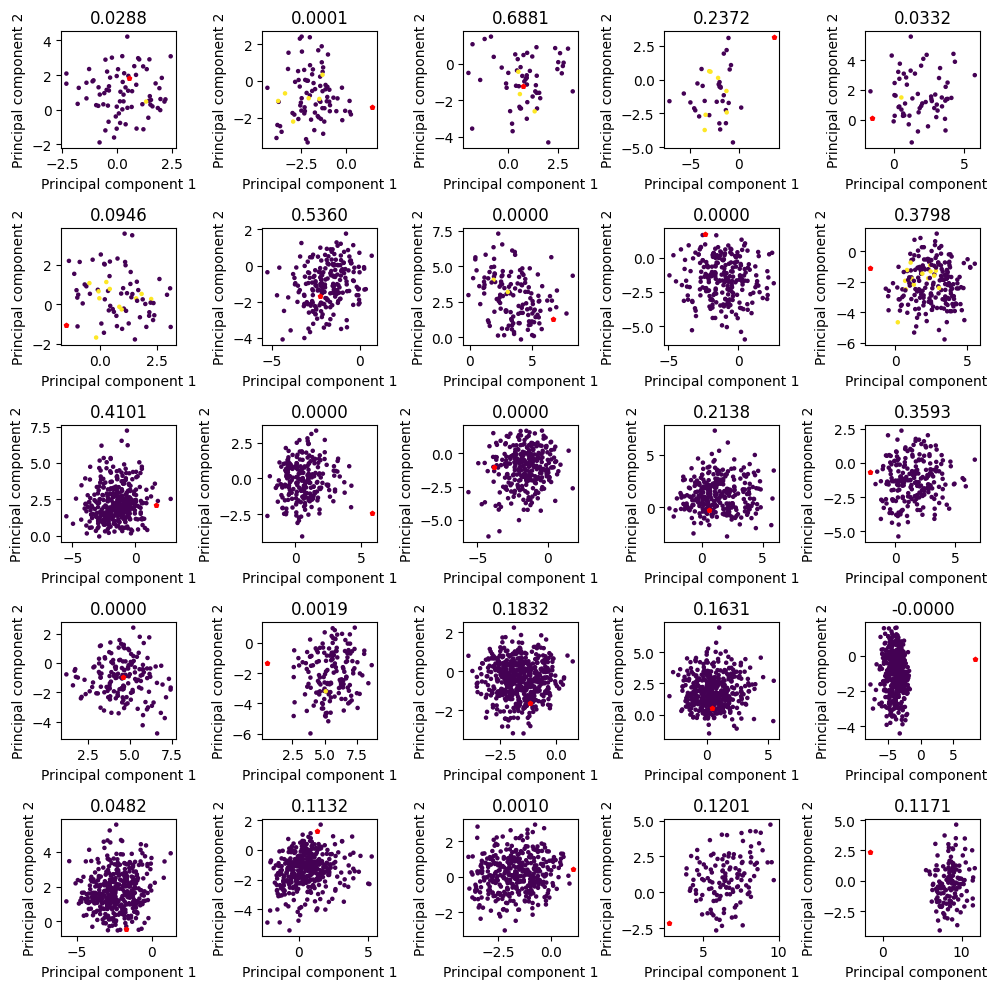

In [44]:
embeddings = domino.pca.transform(test_dp['clip(image)'].to_numpy())
test_X = domino.encoder.transform(embeddings)
pca = PCA(n_components=2)
# test_X = domino.pca.fit_transform(test_dp['clip(image)'].to_numpy())
test_X = pca.fit_transform(np.vstack([test_X, domino.mm.means_]))
centers = test_X[-domino.config.n_slices:]
test_X = test_X[:-domino.config.n_slices]

plt.figure(figsize=(10, 10))
for i in range(domino.config.n_slices):
    plt.subplot(5, 5, i+1)
    cluster = i
    points = test_X[result['slice_preds'].argmax(axis=1)==cluster]
    colors = test_dp[result["slice_preds"].argmax(axis=1)==cluster]['slices'].reshape(-1,)

    plt.scatter(points[:,0], points[:, 1], s=5, c=colors)
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=10, c='r', marker='p', label='cluster centers')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title('{:.4f}'.format(domino.err_entropy[i]))

plt.tight_layout()
plt.show()

## Embed Text

In [45]:
from domino import generate_candidate_descriptions
phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates,
    num_candidates=10_000
)

[nltk_data] Downloading package words to
[nltk_data]     /home/namratadeka/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [46]:
text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=0
)

  0%|          | 0/79 [00:00<?, ?it/s]

In [47]:
test_dp['domino_slices'] = result["slice_preds"]
explore(
    data=test_dp,
    embeddings="clip(image)",
    pred_probs="probs",
    targets="target",
    slices="domino_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
) 

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()

In [52]:
pred_slices = result["slice_preds"].argmax(axis=1)

In [53]:
np.unique(pred_slices[np.where(test_dp['slices'] == 1)[0]])

array([ 3,  6,  8, 11, 17, 18, 21])

,id (PandasSeriesColumn),image (ListColumn),name (PandasSeriesColumn),synset (PandasSeriesColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),probs (ClassificationOutputColumn),split (PandasSeriesColumn),pred (ClassificationOutputColumn),clip(image) (NumpyArrayColumn),domino_slices (NumpyArrayColumn)
0,n07565083_1199,,menu,n07565083,[0.0],1,"[tensor(0.2556), tensor(0.7444)]",test,tensor(0.7444),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
1,n07565083_3523,,menu,n07565083,[0.0],1,"[tensor(0.0491), tensor(0.9509)]",test,tensor(0.9509),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
2,n07579787_10944,,plate,n07579787,[0.0],1,"[tensor(0.4701), tensor(0.5299)]",test,tensor(0.5299),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
3,n07579787_1774,,plate,n07579787,[0.0],1,"[tensor(0.1152), tensor(0.8848)]",test,tensor(0.8848),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
4,n07579787_30767,,plate,n07579787,[0.0],1,"[tensor(0.0280), tensor(0.9720)]",test,tensor(0.9720),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
...,...,...,...,...,...,...,...,...,...,...,...
288,ILSVRC2012_val_00010048,,eggnog,n07932039,[0.0],1,"[tensor(0.3314), tensor(0.6686)]",test,tensor(0.6686),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
289,ILSVRC2012_val_00007708,,espresso,n07920052,[0.0],1,"[tensor(0.4823), tensor(0.5177)]",test,tensor(0.5177),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
290,ILSVRC2012_val_00043737,,"hot pot, hotpot",n07590611,[0.0],1,"[tensor(0.1078), tensor(0.8922)]",test,tensor(0.8922),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"
291,ILSVRC2012_val_00006310,,eggnog,n07932039,[0.0],1,"[tensor(0.1354), tensor(0.8646)]",test,tensor(0.8646),"np.ndarray(shape=(512,))","np.ndarray(shape=(25,))"

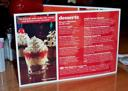
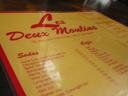
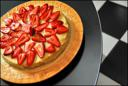
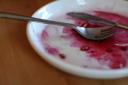
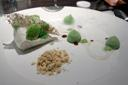
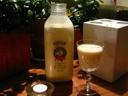
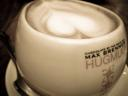
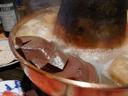
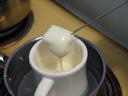
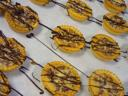

In [54]:
test_dp[pred_slices==8]